# Optimize Ramp Settings

This notebook outlines an example to optimize the ramp settings for a few different types of observations.

In these types of optimizations, we must consider observations constraints such as saturation levels, SNR requirements, and limits on acquisition time.

**Note**: The reported acquisition time does not include obsevatory and instrument-level overheads, such as slew times, filter changes, script compilations, etc. It only includes detector readout times (including reset frames).

In [1]:
## Standard imports

# Makes print and division act like Python 3
from __future__ import print_function, division

# Import the usual libraries
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# Enable inline plotting at lower left
%matplotlib inline
matplotlib.rcParams['image.origin'] = 'lower'
matplotlib.rcParams['image.interpolation'] = 'none'

# seaborn package for making pretty plots, but not necessary
try:
    import seaborn as sns
    params =   {'xtick.direction': 'in', 'ytick.direction': 'in', 'font.family': ['serif'],
                'text.usetex': True, 'text.latex.preamble': ['\usepackage{gensymb}']}
    sns.set_style("ticks", params)
except ImportError:
    print('Seaborn module is not installed. Not strictly required, but is a useful package!')
    
from IPython.display import display, Latex, clear_output

In [2]:
import pynrc
from pynrc import nrc_utils
from pynrc.nrc_utils import (webbpsf, poppy, pix_noise, S)
from pynrc.pynrc_core import table_filter

pynrc.setup_logging('WARNING', verbose=False)

from astropy.table import Table

## Example 1: M-Dwarf companion

We want to observe an M-Dwarf companion (K=18 mag) orbiting an F0V primary (K=10 mag) in the F430M filter. Assume the M-Dwarf flux is not significantly impacted by the primary's PSF (ie., in the background limited regime). In this scenario, the F0V star will saturate much more quickly compared to the fainter companion, so it limits which ramp settings we can use.

We will test a couple different types of observations (direct imaging vs coronagraphy).

In [13]:
# Get stellar spectra and normalize at K-Band
# The stellar_spectrum convenience function creates a Pysynphot spectrum
bp_k = S.ObsBandpass('k')
sp_M2V = pynrc.stellar_spectrum('M2V', 18, 'vegamag', bp_k)
sp_F0V = pynrc.stellar_spectrum('F0V', 10, 'vegamag', bp_k)

In [20]:
# Initiate a NIRCam observation
nrc = pynrc.NIRCam('F430M', wind_mode='WINDOW', xpix=160, ypix=160)

In [22]:
# Set some observing constraints
# Let's assume we want photometry on the primary to calibrate the M-Dwarf for direct imaging
#  - Set well_frac_max=0.75
# Want a SNR~100 in the F430M filter
#  - Set snr_goal=100
res = nrc.ramp_optimize(sp_M2V, sp_bright=sp_F0V, snr_goal=100, well_frac_max=0.75, verbose=True)

BRIGHT1
BRIGHT2
DEEP2
DEEP8
MEDIUM2
MEDIUM8
RAPID
SHALLOW2
SHALLOW4
 Pattern   NGRP NINT   t_int     t_exp     t_acq     SNR      Well     eff   
---------- ---- ---- --------- --------- --------- -------- -------- --------
RAPID         9  510      2.51   1278.96   1421.06    100.0    0.707    2.651
RAPID         9  511      2.51   1281.47   1423.85    100.1    0.707    2.651
RAPID         9  512      2.51   1283.97   1426.64    100.2    0.707    2.651
RAPID         9  513      2.51   1286.48   1429.42    100.3    0.707    2.651
RAPID         9  514      2.51   1288.99   1432.21    100.3    0.707    2.651
RAPID         9  515      2.51   1291.50   1435.00    100.4    0.707    2.651
RAPID         9  516      2.51   1294.00   1437.78    100.5    0.707    2.651
RAPID         9  517      2.51   1296.51   1440.57    100.6    0.707    2.651
RAPID         9  518      2.51   1299.02   1443.36    100.7    0.707    2.651
RAPID         9  519      2.51   1301.53   1446.14    100.8    0.707    2.

In [23]:
# Print the Top 2 settings for each readout pattern
res2 = table_filter(res, 2)
print(res2)

 Pattern   NGRP NINT   t_int     t_exp     t_acq     SNR      Well     eff   
---------- ---- ---- --------- --------- --------- -------- -------- --------
RAPID         9  510      2.51   1278.96   1421.06    100.0    0.707    2.651
RAPID         9  511      2.51   1281.47   1423.85    100.1    0.707    2.651
BRIGHT1       5  700      2.51   1755.43   1950.48     99.9    0.707    2.262
BRIGHT1       5  701      2.51   1757.94   1953.27    100.0    0.707    2.262
BRIGHT2       4  751      2.23   1674.07   1883.33    100.0    0.628    2.303
BRIGHT2       4  752      2.23   1676.30   1885.84    100.0    0.628    2.303
SHALLOW4      2  621      2.51   1557.32   1730.35    100.0    0.707    2.403
SHALLOW4      2  622      2.51   1559.83   1733.14    100.1    0.707    2.403


In [17]:
# Do the same thing, but for coronagraphic mask instead
nrc = pynrc.NIRCam('F430M', mask='MASK430R', pupil='CIRCLYOT', wind_mode='WINDOW', xpix=320, ypix=320)

# We assume that longer ramps will give us the best SNR for time
patterns = ['MEDIUM8', 'DEEP8']
res = nrc.ramp_optimize(sp_M2V, sp_bright=sp_F0V, snr_goal=100, patterns=patterns)

# Take the Top 2 settings for each readout pattern
res2 = table_filter(res, 2)
print(res2)

 Pattern   NGRP NINT   t_int     t_exp     t_acq     SNR      Well     eff   
---------- ---- ---- --------- --------- --------- -------- -------- --------
MEDIUM8      10   73    104.77   7647.91   7725.95     99.4    0.001    1.130
MEDIUM8      10   74    104.77   7752.68   7831.79    100.1    0.001    1.130
DEEP8        20   11    414.79   4562.66   4574.42     99.4    0.003    1.469
DEEP8        20   12    414.79   4977.45   4990.28    103.8    0.003    1.469


#### RESULTS

Based on these two comparisons, it looks like direct imaging is much more efficient in getting to the requisite SNR. In addition, direct imaging gives us a photometric comparison source that is inaccessible with the coronagraph masks.

## Example 2: Exoplanet Coronagraphy

We want to observe GJ 504 for an hour in the F444W filter. 
 - What is the optimal ramp settings to maximize the SNR of GJ 504b?
 - What is the final background sensitivity limit?

In [3]:
# Get stellar spectra and normalize at K-Band
# The stellar_spectrum convenience function creates a Pysynphot spectrum
bp_k = S.ObsBandpass('k')
sp_G0V = pynrc.stellar_spectrum('G0V', 4, 'vegamag', bp_k)

# Choose a representative planet spectrum
planet = pynrc.planets_sb11(atmo='hy3s', mass=8, age=200, entropy=8, distance=17.5)
sp_pl = planet.export_pysynphot()

# Renormalize to F360M = 18.8
bp_l = pynrc.read_filter('F360M') # 
sp_pl = sp_pl.renorm(18.8, 'vegamag', bp_l)

In [4]:
# Initiate a NIRCam observation
nrc = pynrc.NIRCam('F444W', pupil='CIRCLYOT', mask='MASK430R', wind_mode='WINDOW', xpix=160, ypix=160)

In [149]:
res = nrc.ramp_optimize(sp_pl, sp_bright=sp_G0V, tacq_max=3600, verbose=True)

BRIGHT1
BRIGHT2
DEEP2
DEEP8
MEDIUM2
MEDIUM8
RAPID
SHALLOW2
SHALLOW4
 Pattern   NGRP NINT   t_int     t_exp     t_acq     SNR      Well     eff   
---------- ---- ---- --------- --------- --------- -------- -------- --------
DEEP8        20   31    108.11   3351.48   3360.12    635.3    0.448   10.960
DEEP8        20   32    108.11   3459.59   3468.51    645.5    0.448   10.960
DEEP8        20   33    108.11   3567.71   3576.90    655.5    0.448   10.960
DEEP8        20   34    108.11   3675.82   3685.29    665.4    0.448   10.960
DEEP8        20   35    108.11   3783.93   3793.68    675.1    0.448   10.960
DEEP8        19   33    102.54   3383.80   3393.00    637.6    0.425   10.945
DEEP8        19   34    102.54   3486.34   3495.82    647.2    0.425   10.945
DEEP8        19   35    102.54   3588.88   3598.64    656.6    0.425   10.945
DEEP8        19   36    102.54   3691.42   3701.45    665.9    0.425   10.945
DEEP8        19   37    102.54   3793.96   3804.27    675.1    0.425   10.

In [150]:
# Take the Top 2 settings for each readout pattern
res2 = table_filter(res, 2)
print(res2)

 Pattern   NGRP NINT   t_int     t_exp     t_acq     SNR      Well     eff   
---------- ---- ---- --------- --------- --------- -------- -------- --------
BRIGHT1      10  644      5.29   3409.44   3588.88    328.5    0.022    5.483
BRIGHT1      10  645      5.29   3414.73   3594.46    328.8    0.022    5.483
BRIGHT2      10  613      5.57   3416.13   3586.93    384.8    0.023    6.424
BRIGHT2      10  614      5.57   3421.70   3592.78    385.1    0.023    6.424
SHALLOW2     10  267     13.10   3496.65   3571.05    506.5    0.054    8.475
SHALLOW2     10  268     13.10   3509.75   3584.42    507.4    0.054    8.475
SHALLOW4     10  256     13.65   3495.26   3566.59    534.9    0.057    8.957
SHALLOW4     10  257     13.65   3508.91   3580.52    536.0    0.057    8.957
MEDIUM2      10  137     25.63   3511.98   3550.15    573.5    0.106    9.625
MEDIUM2      10  138     25.63   3537.61   3576.07    575.6    0.106    9.625
MEDIUM8      10  129     27.31   3522.57   3558.51    597.4    0

In [5]:
# DEEP8 is the obvious winner
nrc.update_detectors(read_mode='DEEP8', ngroup=20, nint=33)

keys = nrc.multiaccum_times.keys()
keys.sort()
for k in keys:
    print("{:<10}: {: 12.5f}".format(k, nrc.multiaccum_times[k]))

t_acq     :   3576.90168
t_exp     :   3567.70656
t_frame   :      0.27864
t_group   :      5.57280
t_int     :    108.11232
t_int_tot :    108.39096


In [6]:
# Background sensitivity (5 sigma)
sens_dict = nrc.sensitivity(nsig=5, units='vegamag', verbose=True)

Point Source Sensitivity (5-sigma): 22.17 vegamag
Surface Brightness Sensitivity (5-sigma): 23.29 vegamag/arcsec^2


## Example 3: Single-Object Grism Spectroscopy

Similar to the above, but instead we want to obtain a slitless grism spectrum of a K=12 mag M9V dwarf. We want SNR~100 at each grism resolution element.

In [165]:
# M9V star at K=12 mags
bp_k = S.ObsBandpass('k')
sp_M9V = pynrc.stellar_spectrum('M9V', 12, 'vegamag', bp_k)

In [166]:
nrc = pynrc.NIRCam('F444W', pupil='GRISM0', wind_mode='STRIPE', ypix=64)

In [80]:
# Set a minimum of 10 integrations to be robust against cosmic rays
res = nrc.ramp_optimize(sp_M9V, snr_goal=100, nint_min=10, verbose=True)

BRIGHT1
BRIGHT2
DEEP2
DEEP8
MEDIUM2
MEDIUM8
RAPID
SHALLOW2
SHALLOW4
 Pattern   NGRP NINT   t_int     t_exp     t_acq     SNR      Well     eff   
---------- ---- ---- --------- --------- --------- -------- -------- --------
SHALLOW4      8   11     13.28    146.12    149.87    100.4    0.010    8.202
SHALLOW4      8   12     13.28    159.41    163.49    104.9    0.010    8.202
SHALLOW2      9   10     14.31    143.06    146.46     98.7    0.011    8.156
SHALLOW2      9   11     14.31    157.36    161.11    103.5    0.011    8.156
MEDIUM2       5   11     14.31    157.36    161.11     98.7    0.011    7.779
MEDIUM2       5   12     14.31    171.67    175.75    103.1    0.011    7.779
MEDIUM8       4   12     12.94    155.32    159.41     98.2    0.010    7.776
MEDIUM8       4   13     12.94    168.26    172.69    102.2    0.010    7.776
DEEP2         3   12     14.31    171.67    175.75    100.1    0.011    7.554
DEEP2         3   13     14.31    185.97    190.40    104.2    0.011    7.

In [83]:
# Print the Top 2 settings for each readout pattern
res2 = table_filter(res, 2)
print(res2)

 Pattern   NGRP NINT   t_int     t_exp     t_acq     SNR      Well     eff   
---------- ---- ---- --------- --------- --------- -------- -------- --------
RAPID        10  128      3.41    435.98    479.58    100.0    0.003    4.565
RAPID        10  129      3.41    439.39    483.33    100.4    0.003    4.565
BRIGHT1      10   40      6.47    258.86    272.49     99.9    0.005    6.049
BRIGHT1      10   41      6.47    265.34    279.30    101.1    0.005    6.049
BRIGHT2      10   30      6.81    204.37    214.58     99.9    0.005    6.816
BRIGHT2      10   31      6.81    211.18    221.74    101.5    0.005    6.816
SHALLOW2      9   10     14.31    143.06    146.46     98.7    0.011    8.156
SHALLOW2      9   11     14.31    157.36    161.11    103.5    0.011    8.156
SHALLOW4      8   11     13.28    146.12    149.87    100.4    0.010    8.202
SHALLOW4      8   12     13.28    159.41    163.49    104.9    0.010    8.202
MEDIUM2       5   11     14.31    157.36    161.11     98.7    0

In [167]:
# Let's say we choose SHALLOW4, NGRP=8, NINT=11
# Update detector readout
nrc.update_detectors(read_mode='SHALLOW4', ngroup=8, nint=11)

keys = nrc.multiaccum_times.keys()
keys.sort()
for k in keys:
    print("{:<10}: {: 12.5f}".format(k, nrc.multiaccum_times[k]))

t_acq     :    149.86840
t_exp     :    146.12169
t_frame   :      0.34061
t_group   :      1.70305
t_int     :     13.28379
t_int_tot :     13.62440


In [168]:
# Print final wavelength-dependent SNR
# For spectroscopy, the snr_goal is the median over the bandpass
snr_dict = nrc.sensitivity(sp=sp_M9V, forwardSNR=True, units='mJy', verbose=True, image=image)

F444W SNR for M9V source
   Wave      SNR    Flux (mJy)
--------- --------- ----------
     3.80      5.57       5.52
     3.90    162.72       5.48
     4.00    165.50       4.81
     4.10    145.42       3.74
     4.20    150.04       4.38
     4.30    138.93       4.14
     4.40    119.12       3.48
     4.50    106.71       3.11
     4.60     94.12       2.89
     4.70     72.88       2.22
     4.80     69.64       2.29
     4.90     77.22       3.36
     5.00     26.23       1.77
     5.10      0.51       2.17


In [169]:
# Make a mock observed spectral image and extract
wspec, imspec = nrc.gen_psf(sp=sp_M9V)

# Extract 2 spectral x 5 spatial pixels
# First, cut out the central 5 pixels
imspec_sub = nrc_utils.pad_or_cut_to_size(imspec, (5,imspec.shape[1]))

# Sum along the spatial axis
spec = imspec_sub.sum(axis=0)

# Rebin along spectral direction
wspec_rebin = nrc_utils.frebin(wspec, scale=0.5, total=False)
spec_rebin = nrc_utils.frebin(spec, scale=0.5)

# Estimate noise per extraction element
snr_interp = np.interp(wspec_rebin, snr_dict['wave'], snr_dict['snr'])
_spec_rebin = spec_rebin / snr_interp

In [170]:
# Build a quick RSRF
sp_M9V.convert('mjy')
rsrf = spec / sp_M9V.sample(wspec*1e4)
rsrf = nrc_utils.frebin(rsrf, scale=0.5, total=True)

spec_rebin_cal = spec_rebin / rsrf
_spec_rebin_cal = _spec_rebin / rsrf

In [172]:
# Add some random Gaussian noise to the spectrum
spec_rebin_cal += np.random.normal(scale=_spec_rebin_cal)

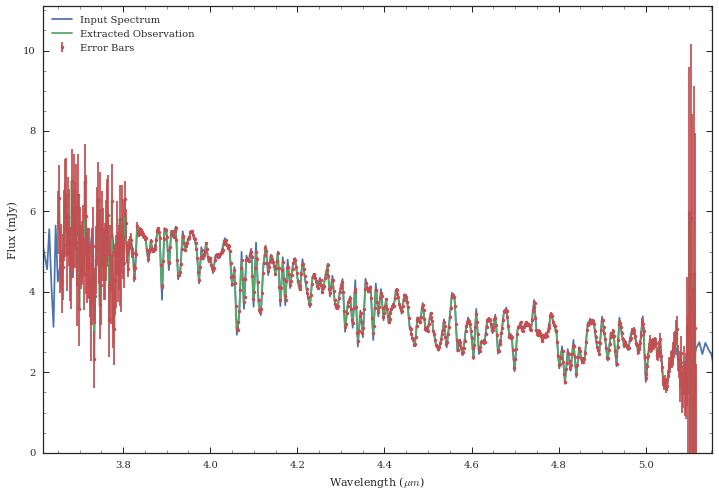

In [173]:
# Overplot the spectrum 
fig, ax = plt.subplots(1,1, figsize=(12,8))

ax.plot(sp_M9V.wave/1e4, sp_M9V.flux, label='Input Spectrum')
ax.plot(wspec_rebin, spec_rebin_cal, label='Extracted Observation')
plt.errorbar(wspec_rebin,spec_rebin_cal, yerr=_spec_rebin_cal, zorder=3,
             fmt='.', label='Error Bars')
ax.legend(loc='best')

xr = np.array([wspec_rebin.min(), wspec_rebin.max()])
dx = 0.025*(xr[1]-xr[0])
xr[0] -= dx; xr[1] += dx

yr = np.array([np.min(spec_rebin_cal-_spec_rebin_cal), np.max(spec_rebin_cal+_spec_rebin_cal)])
dy = 0.05*(yr[1]-yr[0])
yr[0] -= dy; yr[1] += dy
yr[0] = np.max([0,yr[0]])

ax.set_xlim(xr)
ax.set_ylim(yr)
ax.set_xlabel('Wavelength ($\mu m$)')
ax.set_ylabel('Flux (mJy)')

ax.minorticks_on()


#ax.set_xlim([3.6,3.8])
#ax.set_ylim([5,10])


## Example 4: Exoplanet Transit Spectroscopy

Let's say we want to observe an exoplanet transit using NIRCam grisms in the F322W2 filter. 

We assume a 2.1-hour transit duration for a K6V star (K=8.4 mag).

In [3]:
nrc = pynrc.NIRCam('F322W2', pupil='GRISM0', wind_mode='STRIPE', ypix=64)

In [4]:
# K6V star at K=8.4 mags
bp_k = S.ObsBandpass('k')
sp_K6V = pynrc.stellar_spectrum('K6V', 8.4, 'vegamag', bp_k)

In [5]:
# Constraints
well     = 0.5        # keep well below 50% full
tacq     = 2.1*3600.  # 2.1 hour transit duration
ng_max   = 30         # transit spectroscopy allows for up to 30 groups per integrations
nint_max = int(1e6)   # Effectively no limit on number of integrations

# Let's bin the spectrum to R~100
# dw_bin is a passable parameter for specifiying spectral bin sizes
R = 100
dw_bin = (nrc.bandpass.avgwave() / 10000) / R

In [6]:
res = nrc.ramp_optimize(sp_K6V, tacq_max=tacq, nint_max=nint_max, ng_max=ng_max, well_frac_max=well,
                        dw_bin=dw_bin, verbose=True)

BRIGHT1
BRIGHT2
DEEP2
DEEP8
MEDIUM2
MEDIUM8
RAPID
SHALLOW2
SHALLOW4
 Pattern   NGRP NINT   t_int     t_exp     t_acq     SNR      Well     eff   
---------- ---- ---- --------- --------- --------- -------- -------- --------
BRIGHT1      24  461     16.01   7380.00   7537.02  30985.5    0.499  356.910
BRIGHT1      24  462     16.01   7396.01   7553.37  31019.1    0.499  356.910
BRIGHT1      24  463     16.01   7412.01   7569.72  31052.7    0.499  356.910
BRIGHT1      24  464     16.01   7428.02   7586.07  31086.2    0.499  356.910
BRIGHT1      24  465     16.01   7444.03   7602.42  31119.7    0.499  356.910
BRIGHT1      23  481     15.33   7372.50   7536.34  30950.8    0.478  356.526
BRIGHT1      22  502     14.65   7352.41   7523.39  30887.5    0.457  356.102
BRIGHT2      23  470     15.67   7363.99   7524.07  30620.2    0.489  353.004
BRIGHT2      23  471     15.67   7379.66   7540.08  30652.7    0.489  353.004
BRIGHT2      23  472     15.67   7395.32   7556.09  30685.2    0.489  353.

In [7]:
# Print the Top 2 settings for each readout pattern
res2 = table_filter(res, 2)
print(res2)

 Pattern   NGRP NINT   t_int     t_exp     t_acq     SNR      Well     eff   
---------- ---- ---- --------- --------- --------- -------- -------- --------
RAPID        30  714     10.22   7295.87   7539.06  30603.2    0.319  352.458
RAPID        30  715     10.22   7306.08   7549.62  30624.6    0.319  352.458
BRIGHT1      24  461     16.01   7380.00   7537.02  30985.5    0.499  356.910
BRIGHT1      24  462     16.01   7396.01   7553.37  31019.1    0.499  356.910
BRIGHT2      23  470     15.67   7363.99   7524.07  30620.2    0.489  353.004
BRIGHT2      23  471     15.67   7379.66   7540.08  30652.7    0.489  353.004
SHALLOW2     10  461     16.01   7380.00   7537.02  30641.3    0.499  352.945
SHALLOW2     10  462     16.01   7396.01   7553.37  30674.5    0.499  352.945
SHALLOW4      9  491     14.99   7358.54   7525.78  29834.4    0.467  343.907
SHALLOW4      9  492     14.99   7373.53   7541.11  29864.8    0.467  343.907
MEDIUM2       5  514     14.31   7353.09   7528.16  30461.9    0

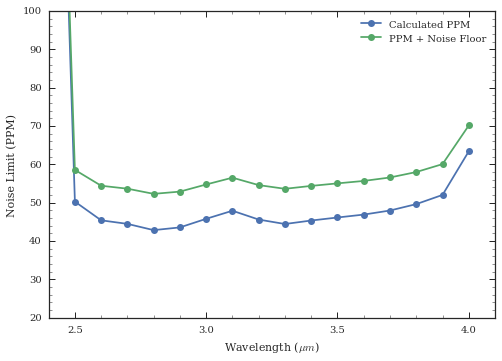

In [10]:
# Even though BRIGHT1 has a slight efficiency preference over RAPID 
# and BRIGHT2, we decide to choose RAPID, because we are convinced 
# that saving all data (and no coadding) is a better option. 
# If APT informs you that the data rates or total data shorage is 
# an issue, you can select one of the other options.

# Update to RAPID, ngroup=30, nint=716 and plot PPM
nrc.update_detectors(read_mode='RAPID', ngroup=30, nint=716)
snr_dict = nrc.sensitivity(sp=sp_K6V, dw_bin=dw_bin, forwardSNR=True, units='Jy')
wave = np.array(snr_dict['wave'])
snr  = np.array(snr_dict['snr'])

# Let assume bg subtraction of something with similar noise
snr /= np.sqrt(2.)
ppm = 1e6 / snr

# NOTE: We have up until now neglected to include a "noise floor"
# which represents the expected minimum achievable ppm from
# unknown systematics. To first order, this can be added in 
# quadrature to the calculated PPM.
noise_floor = 30 # in ppm
ppm_floor = np.sqrt(ppm**2 + noise_floor**2)

plt.plot(wave, ppm, marker='o', label='Calculated PPM')
plt.plot(wave, ppm_floor, marker='o', label='PPM + Noise Floor')
plt.xlabel('Wavelength ($\mu m$)')
plt.ylabel('Noise Limit (PPM)')
plt.xlim([2.4,4.1])
plt.ylim([20,100])
plt.legend(loc=0)
plt.minorticks_on()

## Example 5: Extended Souce

Expect some faint galaxies of 25 ABMag/arcsec^2 in our field. What is the best we can do with 10,000 seconds of acquisition time? 

In [28]:
# Detection bandpass is F200W
nrc = pynrc.NIRCam('F200W')

# Flat spectrum (in photlam) with ABMag = 25 in the NIRCam bandpass
sp = pynrc.stellar_spectrum('flat', 25, 'abmag', nrc.bandpass)

In [30]:
res = nrc.ramp_optimize(sp, is_extended=True, tacq_max=10000, tacq_frac=0.05, verbose=True)

BRIGHT1
BRIGHT2
DEEP2
DEEP8
MEDIUM2
MEDIUM8
RAPID
SHALLOW2
SHALLOW4
 Pattern   NGRP NINT   t_int     t_exp     t_acq     SNR      Well     eff   
---------- ---- ---- --------- --------- --------- -------- -------- --------
MEDIUM8      10    8   1052.20   8417.63   8503.52      9.8    0.000    0.106
MEDIUM8       9    9    944.84   8503.52   8600.15      9.8    0.000    0.106
MEDIUM8       9   10    944.84   9448.36   9555.73     10.4    0.000    0.106
MEDIUM8      10    9   1052.20   9469.83   9566.46     10.4    0.000    0.106
MEDIUM8       9   11    944.84  10393.19  10511.30     10.9    0.000    0.106
MEDIUM8      10   10   1052.20  10522.03  10629.40     11.0    0.000    0.106
DEEP8         8    5   1589.04   7945.21   7998.89      9.4    0.000    0.105
DEEP8         7    6   1374.31   8245.84   8310.26      9.6    0.000    0.105
MEDIUM8       8   11    837.47   9212.15   9330.25     10.2    0.000    0.105
DEEP8         6    8   1159.57   9276.57   9362.46     10.2    0.000    0.

In [33]:
# MEDIUM8 10 10 looks like a good option
nrc.update_detectors(read_mode='MEDIUM8', ngroup=10, nint=10, verbose=True)

New Ramp Settings:
  read_mode :  MEDIUM8
  nf        :        8
  nd2       :        2
  ngroup    :       10
  nint      :       10
New Detector Settings
  wind_mode :     FULL
  xpix      :     2048
  ypix      :     2048
  x0        :        0
  y0        :        0
New Ramp Times
  t_group   :  107.368
  t_frame   :   10.737
  t_int     : 1052.203
  t_exp     : 10522.035
  t_acq     : 10629.402


In [52]:
# Calculate flux/mag for various nsigma detection limits
tbl = Table(names=('Sigma', 'Source (nJy)',    'Extended (nJy/asec^2)', 
                            'Source (AB Mag)', 'Extended (AB Mag/asec^2)'))
tbl['Sigma'].format = '.0f'
for k in tbl.keys()[1:]:
    tbl[k].format = '.2f'

for sig in [1,3,5,10]:
    snr_dict1 = nrc.sensitivity(nsig=sig, units='nJy', verbose=False)
    snr_dict2 = nrc.sensitivity(nsig=sig, units='abmag', verbose=False)
    tbl.add_row([sig, snr_dict1[0]['sensitivity'], snr_dict1[1]['sensitivity'],
                snr_dict2[0]['sensitivity'], snr_dict2[1]['sensitivity']])

In [53]:
tbl

Sigma,Source (nJy),Extended (nJy/asec^2),Source (AB Mag),Extended (AB Mag/asec^2)
float64,float64,float64,float64,float64
1,0.92,32.31,31.50,27.63
3,2.76,97.36,30.30,26.43
5,4.63,163.00,29.74,25.87
10,9.40,329.71,28.97,25.10
